# Игры — Формирование модели монетизации

**Описание проекта**

Сформировать модель монетизации игрового приложения.

Многие игры зарабатывают с помощью рекламы. И все они сталкиваются с противоречием:
- Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
- Но  чем позже создатели игры включат рекламу, тем меньше они заработают.

Пока создатели игры планируют показывать её на экране выбором постройки. Необходимо помочь им не уйти в минус.

**Цель исследования**

1. Помочь бизнесу выбрать оптимальное время для запуска рекламы.
2. Зная расходы на продвижение игры, рассчитать её окупаемость при разных сценариях. 
3. Проверка гипотез 

**Ход исследования**

Исследование содержит следующие этапы:

1. Изучение данных из файлов.
2. Предобработка данных.
   * Обработка пропусков
   * Обработка типов данных
   * Обработка дубликатов
   * Добавление новых столбцов
3. Исследовательский анализ данных.
4. Расчет метрик
5. Проверка гипотез
6. Общий вывод и рекомендации


## Материалы

* Презентация   <https://disk.yandex.ru/i/Hr7sCK9dNxiXng>
* Дашборд <https://public.tableau.com/app/profile/kate.zaikova/viz/final_project_16683338593550/Dashboard2>

## Выгрузка данных и их изучение 

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from scipy import stats as st

In [2]:
# чтение файла game_actions.csv и сохранение в переменной actions
if os.path.exists('/datasets/game_actions.csv'):
    actions = pd.read_csv('/datasets/game_actions.csv', sep = ',')
else:
    actions = pd.read_csv('game_actions.csv', sep = ',')

In [3]:
# просмотр первых пяти строк таблицы actions
actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


В таблице 5 столбцов.

Согласно документации к данным:
* event_datetime — время события;
* event — одно из трёх событий:
    * building — объект построен,
    * finished_stage_1 — первый уровень завершён,
    * project — проект завершён;
* building_type — один из трёх типов здания:
    * assembly_shop — сборочный цех,
    * spaceport — космопорт,
    * research_center — исследовательский центр;
* user_id` — идентификатор пользователя;
* project_type — тип реализованного проекта.

In [4]:
# получение общей информации о данных в таблице actions
actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [5]:
# определеним количество пропусков в процентах
(actions.isna().mean().round(4))*100

event_datetime     0.00
event              0.00
building_type      5.66
user_id            0.00
project_type      98.62
dtype: float64

In [6]:
# проверим значения колонки project_type
actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

Тип проекта или пропуски, или "постройка спутника". Тип - "победа над игроком" отсутствует. Возможно произошед какой-то сбой и данные не подгрузились.

In [7]:
# проверим значения колонки building_type
actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [8]:
# проверим произошедшие события в момент, когда постройки отсутствовали
actions[actions['building_type'].isna()]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

Теперь понятна откуда взялись пропуски, игрок просто уже завершил 1 уровень.

In [9]:
# проверим наличие явных дубликатов
actions.duplicated().sum()

1

In [10]:
# чтение файла ad_costs.csv и сохранение в переменной ad_costs
if os.path.exists('/datasets/ad_costs.csv'):
    ad_costs = pd.read_csv('/datasets/ad_costs.csv', sep = ',')
else:
    ad_costs = pd.read_csv('ad_costs.csv', sep = ',')

In [11]:
# просмотр первых пяти строк таблицы ad_costs
ad_costs.head(5)

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


В таблице 3 столбца.
* day - день, в который был совершен клик по объявлению
* source - источник трафика
* cost - стоимость кликов

In [12]:
# получение общей информации о данных в таблице games
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [13]:
# проверим наличие явных дубликатов
ad_costs.duplicated().sum()

0

In [14]:
# проверим значения колонки source
ad_costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [15]:
# при помощи метда describe() посмотрим на значения в столбце cost
ad_costs['cost'].describe()

count     28.000000
mean     271.556321
std      286.867650
min       23.314669
25%       66.747365
50%      160.056443
75%      349.034473
max      969.139394
Name: cost, dtype: float64

Стандартное отклонение большое, выбросы присутствуют

In [16]:
# чтение файла user_source.csv и сохранение в переменной user_source
if os.path.exists('/datasets/user_source.csv'):
    user_source = pd.read_csv('/datasets/user_source.csv', sep = ',')
else:
    user_source = pd.read_csv('user_source.csv', sep = ',')

In [17]:
# просмотр первых пяти строк таблицы user_source
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


В таблице 2 столбца.
* user_id - идентификатор пользователя
* source - источников, с которого пришёл пользователь, установивший приложение

In [18]:
# получение общей информации о данных в таблице user_source
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [19]:
# проверим значения колонки source
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

In [20]:
# проверим наличие явных дубликатов
user_source.duplicated().sum()

0

### Вывод:

В таблице actions:
* пропуски есть в столбцах building_type - 5.66% и project_type - 98.62%
* в столбце project_type из непропущенных значений присутствует только тип - постройка спутника.
* пропущенные значения в столбце project_type заполним исходя из столбца event.
* в столбце building_type пропуски только у тех игроков, которые завершили игру, поэтому заполним их как постройка завершена.
* в таблице присутствует один явный дубликат, в предобработке мы его удалим.
* заменим тип данных в столбце event_datetime на datetime.

В таблице ad_costs:
* пропусков нет
* дубликатов нет

В таблице user_source:
* пропусков нет
* дубликатов нет

## Предобработка данных

### Обработка пропусков

In [21]:
# в столбце project_type заполняем пропуски завершивших уровень пользователей, как спутниковая_орбитальная_ сборка
actions.loc[actions['project_type'].isna() &
                 (actions['event'] == 'project'),
                 'project_type'] = 'satellite_orbital_assembly'

In [22]:
# в столбце project_type заполняем пропуски завершивших уровень пользователей, как победа над первым врагом
actions.loc[actions['project_type'].isna() &
                 (actions['event'] == 'finished_stage_1'),
                 'project_type'] = 'victory_over_enemy'

In [23]:
# в столбце project_type заполняем пропуски не завершивших уровень пользователей, как уровень не завершен
actions.loc[actions['project_type'].isna() &
                 (actions['event'] == 'building'),
                 'project_type'] = 'level_not_completed'

In [24]:
# заполняем пропуски в колонке building_type значением project is built
actions['building_type'] = actions['building_type'].fillna('project_is_built')

In [25]:
# определеним количество пропусков в процентах после заполнения пропусков
(actions.isna().mean().round(4))*100

event_datetime    0.0
event             0.0
building_type     0.0
user_id           0.0
project_type      0.0
dtype: float64

### Обработка типа данных

In [26]:
# преобразуем тип данных со временем
actions['event_datetime'] = pd.to_datetime(actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day']).dt.date

### Обработка дубликатов

In [27]:
# удалим явные дубликаты при помощи метода drop_duplicates() и проверим все ли дубликаты удалились.
actions = actions.drop_duplicates().reset_index(drop=True) 
actions.duplicated().sum()

0

In [28]:
# просмотрим общую инфо после предобработки 
for i in actions, ad_costs: 
    i.info() 
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   135639 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    135639 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes



### Добавление данных в таблицу actions

Найдем время прохождения уровня

In [29]:
# добавим в переменную user_filter всех игроков кто прошел первый уровень
user_filter = actions[actions['event'] == 'finished_stage_1']['user_id']

In [30]:
# создадим переменную level_time, в которой сгрупируем всех прошедших первый уровень по user_id
# и найдем максимальное и минимальное время
level_time = (actions
              .query('user_id in @user_filter')
              .groupby('user_id')
              .agg({'event_datetime':['min','max']})
              .reset_index())

In [31]:
# найдем время прохождения уровня
level_time['level_time'] = (level_time[('event_datetime', 'max')] - level_time[('event_datetime', 'min')])

In [32]:
# удалим уровни в строке
level_time.columns = level_time.columns.droplevel(1)

In [33]:
# сбросим индексы и отсортируем по level_time
level_time = level_time.reset_index().sort_values(by='level_time')

In [34]:
# присоеденим время прохождения уровня к таблице actions и посмотреим первые 5 строк игроков прошедших 1 уровень
actions = actions.merge(level_time[['level_time', 'user_id']], on= 'user_id', how='left')
actions.query('project_type=="victory_over_enemy"').head()

,event_datetime,event,building_type,user_id,project_type,level_time
6659,2020-05-04 19:47:29,finished_stage_1,project_is_built,ced7b368-818f-48f6-9461-2346de0892c5,victory_over_enemy,0 days 19:34:08
13134,2020-05-05 13:22:09,finished_stage_1,project_is_built,7ef7fc89-2779-46ea-b328-9e5035b83af5,victory_over_enemy,1 days 12:59:21
15274,2020-05-05 18:54:37,finished_stage_1,project_is_built,70db22b3-c2f4-43bc-94ea-51c8d2904a29,victory_over_enemy,1 days 05:12:42
16284,2020-05-05 21:27:29,finished_stage_1,project_is_built,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,victory_over_enemy,1 days 20:30:27
19650,2020-05-06 06:02:22,finished_stage_1,project_is_built,58e077ba-feb1-4556-a5a0-d96bd04efa39,victory_over_enemy,1 days 10:38:42


Добавим к таблице actions данные из таблицы user_source, чтобы видеть из какого источника пришел наш игрок

In [35]:
actions = actions.merge(user_source, on='user_id', how='left')
actions.head()

,event_datetime,event,building_type,user_id,project_type,level_time,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_not_completed,NaT,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_not_completed,11 days 05:29:10,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,level_not_completed,12 days 11:51:42,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,level_not_completed,NaT,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,level_not_completed,7 days 14:17:30,yandex_direct


Добавим столбец с revenue в таблицу actions. Нам известно, что с каждого показа рекламы мы получаем 0.07 у.е.

In [36]:
def add_cost(data):
    if data == 'building':
        return .07
    else:
        return 0


actions['revenue'] = actions['event'].apply(add_cost)
actions.head()

,event_datetime,event,building_type,user_id,project_type,level_time,source,revenue
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,level_not_completed,NaT,youtube_channel_reklama,0.07
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,level_not_completed,11 days 05:29:10,facebook_ads,0.07
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,level_not_completed,12 days 11:51:42,instagram_new_adverts,0.07
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,level_not_completed,NaT,facebook_ads,0.07
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,level_not_completed,7 days 14:17:30,yandex_direct,0.07


### Вывод:

В предобработке данных:
* Заменили пропуски исходя из произошедших событий в event в столбцах:
   * project_type:
     * на satellite_orbital_assembly, если в event стоит project, 
     * на victory_over_enemy, если в event стоит finished_stage_1,
     * на level_not_completed, если в event стоит building.
   * building_type:
     * на project_is_built, если в event стоит finished_stage_1, либо project.
* Заменили тип данных в таблицах:
   * actions в столбце event_datetime на datetime
* Удалили один явный дубликат с таблице actions    
* Добавили новые столбцы в таблицу actions: время прохождения уровня, канал привлечения и доход с просмотра рекламы. 

## Исследовательский анализ данных

### Общее количество игроков за весь период

In [37]:
player_cnt = actions['user_id'].nunique()
player_cnt

13576

### Количество игроков, прошедшие первый уровень

In [38]:
player_finish = actions.query('event=="finished_stage_1"')['user_id'].count()
player_finish 

5817

### Доля игроков, которые завершили 1 уровень от общего числа игроков

In [39]:
ratio = (100*player_finish / player_cnt).round(2)
ratio

42.85

### Количество игроков, пришедших с каждого источника трафика

In [40]:
# для просмотра по каким рекламным каналам шло привлечение игроков, сгрупируем их профили по source
source = (user_source.groupby('source').agg({'user_id': 'nunique'})
                                       .sort_values(by=['user_id'],ascending=False)
                                       .reset_index()
                                       .rename(columns={'user_id':'count_user'}))
source['percent'] = (source['count_user'] / player_cnt)*100
source.style.format({'percent': '{:.2f}%'})

,source,count_user,percent
0,yandex_direct,4817,35.48%
1,instagram_new_adverts,3347,24.65%
2,facebook_ads,2726,20.08%
3,youtube_channel_reklama,2686,19.78%


### Общуя сумму расходов на маркетинг

In [41]:
costs_sum = ad_costs['cost'].sum().astype(int)
costs_sum

7603

### Общие затраты на каждый источник трафика

In [42]:
costs = (ad_costs.groupby('source').agg({'cost': 'sum'})
                                     .sort_values(by=['cost'],ascending=False)
                                     .reset_index())
costs['percent'] = (costs['cost'] / costs_sum)*100
costs.style.format({'percent': '{:.2f}%'})

,source,cost,percent
0,yandex_direct,2233.111449,29.37%
1,instagram_new_adverts,2161.441691,28.43%
2,facebook_ads,2140.904643,28.16%
3,youtube_channel_reklama,1068.119204,14.05%


### Количество событий за весь период

In [43]:
events_cnt = actions['event'].count()
events_cnt

135639

### Количество событий на каждый этап уровня

In [44]:
events = (actions.groupby('event').agg({'building_type':'count'})
                                  .sort_values(by=['building_type'],ascending=False)
                                  .reset_index()
                                  .rename(columns={'building_type':'count'}))
events['percent'] = (events['count'] / events_cnt)*100
events.style.format({'percent': '{:.2f}%'})

,event,count,percent
0,building,127956,94.34%
1,finished_stage_1,5817,4.29%
2,project,1866,1.38%


### Cамая популярная постройка

In [45]:
type_pop = (actions.query('building_type!="project_is_built"').groupby('building_type').agg({'user_id':'count'})
                                  .sort_values(by=['user_id'],ascending=False)
                                  .reset_index()
                                  .rename(columns={'user_id':'count'}))
type_pop['percent'] = (type_pop['count'] / events['count'][0])*100
type_pop.style.format({'percent': '{:.2f}%'})

,building_type,count,percent
0,spaceport,59325,46.36%
1,assembly_shop,54494,42.59%
2,research_center,14137,11.05%


### Количество построек на одного игрока

In [46]:
cnt = (actions.query('event=="building"')
              .pivot_table(index='user_id', values='event', aggfunc='count')
              .reset_index()
              .sort_values(by=['event'],ascending=False)
              .rename(columns={'event':'cnt_user'}))
cnt

,user_id,cnt_user
8799,a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20
8644,a2f85d5e-5a53-43ee-9d41-9e1def085562,20
10120,bf542075-e3a2-4e79-82d8-3838e86d2a25,20
1592,1cb5b622-be18-488e-b699-6136a57eb470,20
11329,d6aca06a-cd75-4cd8-b8cd-240a3c163884,20
...,...,...
6601,7ac32352-627b-421c-9319-b77a37947625,1
4494,531a93d9-f57d-4b60-8eec-ee709ff7c67c,1
11954,e17fd642-a43d-41d4-86a8-c81c6107f9cc,1
7406,8a6262b0-0521-4691-bfd2-8d74cf7a5e93,1


### Среднее количество построек на игрока

In [47]:
cnt.mean()

cnt_user    9.425162
dtype: float64

### Распределение количества построенных зданий и количество пользователей, которые построили их

Text(0.5, 0, 'Кол-во построенных зданий')

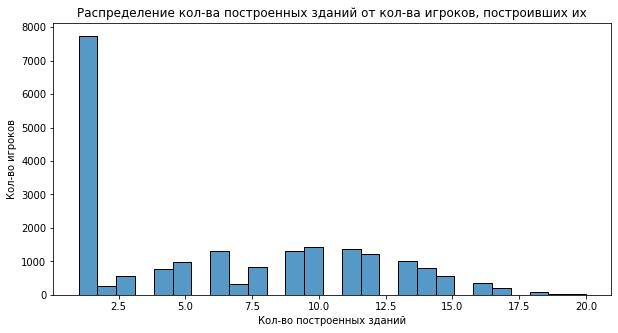

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(data =actions.groupby(['user_id', 'project_type'])['building_type']
                          .count()
                          .reset_index() , x = 'building_type')
plt.title("Распределение кол-ва построенных зданий от кол-ва игроков, построивших их")
plt.ylabel("Кол-во игроков")
plt.xlabel("Кол-во построенных зданий")

### Вывод:

* Доля игроков, которые завершили 1 уровень от общего числа игроков - 56,59%
* Всех больше игроков приходит с канала - "yandex_direct" 35,48%, всех меньше с канала youtube_channel_reklama 19,78%
* Затраты на маркетинг от общего бюджета:
   * yandex_direct - 29.37%
   * instagram_new_adverts - 28.43%
   * facebook_ads - 28.16%
   * youtube_channel_reklama - 14.05%
* 93.10% - игроков на стадии постройки зданий, 5.23% - завершили уровень победой над врагом, 1.68% - реализовали проект
* самая популярная постройка spaceport (47,72% доля от всех построек)
* Максимальное количество построек на игрока - 20
* Минимальное количество построек на игрока  - 1 
* Среднее количество построек на игрока -9,43
* Очень много игроков строят всего 1 постройку (около 8000 игроков)



## Расчет бизнес-показателей

### DAU, WAU и sticky factor

Оценим пользовательскую активность по трем показателям: DAU, WAU и sticky factor. 

In [49]:
# выделим год, номер недели из времени начала пользования приложением
actions['year'] = actions['event_datetime'].dt.year
actions['week'] = actions['event_datetime'].dt.isocalendar().week
actions['date'] = actions['event_datetime'].dt.date

In [50]:
# сгрупируем по дате (году, недели) и посчитаем уникальных пользователей
dau_total = (
    actions.groupby('date').agg({'user_id': 'nunique'}).mean()
)

wau_total = (
    actions.groupby(['year', 'week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

In [51]:
sticky_factor = dau_total / wau_total * 100 

In [52]:
print(f"DAU - {dau_total[0]:.2f} \n WAU - {wau_total[0]:.2f} \n sticky_factor - {sticky_factor[0]:.2f}")

DAU - 2884.88 
 WAU - 6120.00 
 sticky_factor - 47.14


#### Вывод:

* Количество уникальных пользователей в день ~ 2885 
* Количество уникальных пользователей в неделю - 6120
* Регулярно возвращаются в игру - 47,14% (очень неплохой результат)

### Retention Rate, LTV, CAC и ROI

Так как нам надо определить момент, когда лучше начинать показывать рекламу и в тоже время учесть такие противоречия как:
- пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
- но  чем позже создатели игры включат рекламу, тем меньше они заработают.

И у нас есть график распределения количества построенных зданий игроками. На нем видно, что многие игроки уходят после первой постройки, можно предположить, что если мы начнем транслировать рекламу с первой постройки, то количество игроков, покинувших игру еще больше увеличится. Поэтому при расчета окупаемости посмотрим 2 варианта:
* 1 вариант - рекламу начинаем показывать с первой постройки,
* 2 вариант - рекламу начинаем показывать со второй постройки.


#### 1 вариант: показ рекламы после первой постройки

Создадим таблицу с доходами от просмотра рекламы revenue_ad

In [53]:
# получаем таблицу с user_id, event_datetime, revenue
revenue_ad = actions[['user_id', 'event_datetime', 'revenue']]
# оставим в таблице только данные с показами реклам
revenue_ad = revenue_ad[revenue_ad['revenue'] > 0]
revenue_ad.head()

,user_id,event_datetime,revenue
0,55e92310-cb8e-4754-b622-597e124b03de,2020-05-04 00:00:01,0.07
1,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-04 00:00:03,0.07
2,6edd42cc-e753-4ff6-a947-2107cd560710,2020-05-04 00:00:16,0.07
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,2020-05-04 00:00:16,0.07
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,2020-05-04 00:00:35,0.07


In [54]:
# проверим общую информацию о таблице
revenue_ad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127956 entries, 0 to 135636
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         127956 non-null  object        
 1   event_datetime  127956 non-null  datetime64[ns]
 2   revenue         127956 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.9+ MB


Соберём функции для создания профилей, расчёта удержания, LTV и ROI: 

In [55]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'event_datetime'])
        .groupby('user_id')
        .agg(
            {
                'event_datetime': 'first',
                'source': 'first',
            }
        )
        .rename(columns={'event_datetime': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['day'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['day', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['day', 'source'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['cost'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['day', 'source', 'acquisition_cost']],
        on=['day', 'source'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [56]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('day <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        actions[['user_id', 'event_datetime']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['day'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [57]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('day <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_datetime', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['day'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [58]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=1):

    # задаём размер сетки для графиков
    plt.figure(figsize=(18, 12))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 2)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['day', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='day', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.rcParams.update({'font.size': 15,})
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(3, 2, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Доход')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(3, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['day']]
    filtered_data = ltv_history.pivot_table(
        index='day', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Доход')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    
    # третий график — динамика cac
    ax3 = plt.subplot(3, 2, 5, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['day']]
    filtered_data = cac_history.pivot_table(
        index='day', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.ylabel('Затраты на привлечение')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(3, 2, 3)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.ylabel('Окупаемость в %')
    plt.title('ROI')
    
    # пятый график — динамика roi
    ax5 = plt.subplot(3, 2, 4, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['day']]
    filtered_data = roi_history.pivot_table(
        index='day', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.ylabel('Окупаемость в %')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


In [59]:
# Загрузим профили пользователей, для этого вызовем функцию get_profiles
profiles = get_profiles(actions, revenue_ad, ad_costs)
profiles.head()

,user_id,first_ts,source,day,month,payer,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,facebook_ads,2020-05-06,2020-05-01,True,0.515890
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,yandex_direct,2020-05-06,2020-05-01,True,0.272466
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,youtube_channel_reklama,2020-05-05,2020-05-01,True,0.221782
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,instagram_new_adverts,2020-05-05,2020-05-01,True,0.394436
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,facebook_ads,2020-05-05,2020-05-01,True,0.374907


In [60]:
# Определим минимальную дату привлечения пользователей
min_date = actions['event_datetime'].min()
min_date

Timestamp('2020-05-04 00:00:01')

In [61]:
# Определим максимальную дату привлечения пользователей
max_date = actions['event_datetime'].max()
max_date

Timestamp('2020-06-05 12:32:49')

In [62]:
observation_date = datetime(2020, 6, 5).date()  # момент анализа
horizon_days = 7  # горизонт анализа 

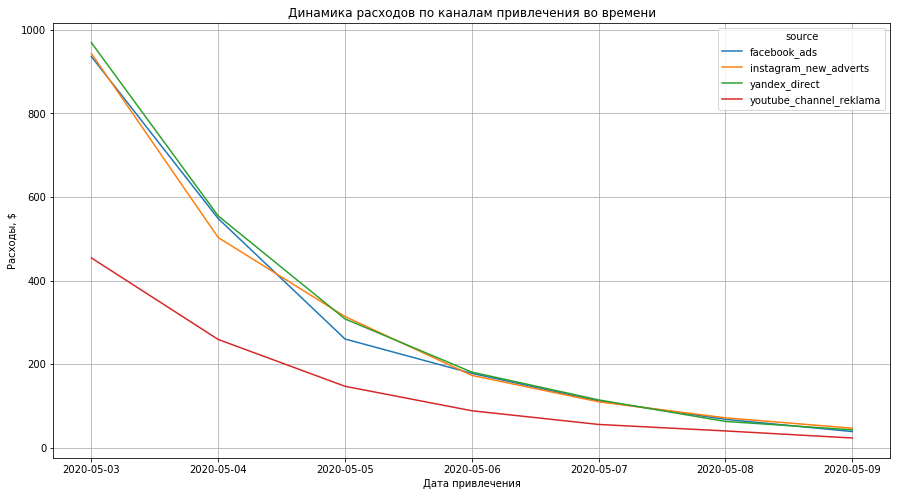

In [63]:
# Построим график, при помощи plot(), для просмотра как распределенны траты на рекламу во времени по источникам.
ad_costs.pivot_table(index='day', columns='source', values='cost', aggfunc='sum').plot(grid=True, figsize=(15, 8))
plt.ylabel('Расходы, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика расходов по каналам привлечения во времени')
plt.show()

In [64]:
# Рассчитаем средний CAC на одного пользователя для каждого источника трафика

(profiles.groupby('source').agg({'acquisition_cost': 'mean'})
                           .rename(columns={'acquisition_cost': 'cac'})
                           .sort_values(by=['cac'],ascending=False)
                           .reset_index())

,source,cac
0,facebook_ads,0.442048
1,instagram_new_adverts,0.363979
2,yandex_direct,0.262398
3,youtube_channel_reklama,0.228553


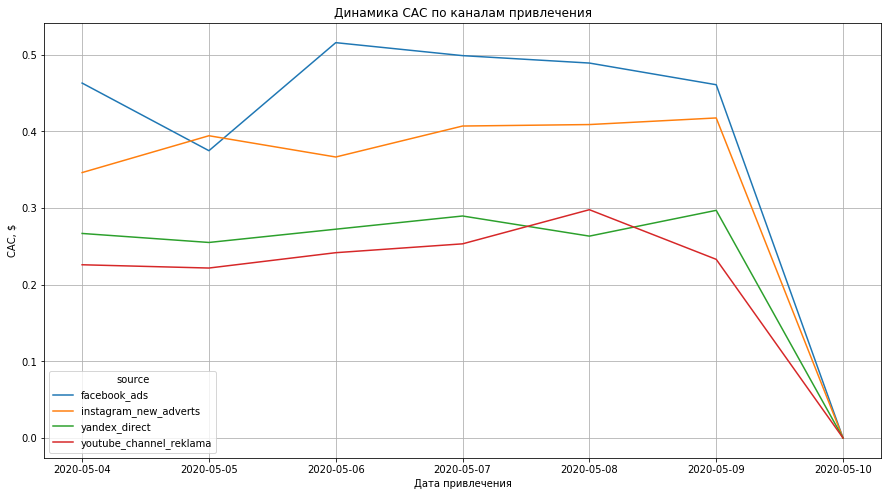

In [65]:
# Построим график динамики САС по источникам во времени
profiles.pivot_table(index='day', columns='source', values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(15, 8))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Анализ общей окупаемости

In [66]:
# посчитаем LTV и ROI, вызвав функцию get_ltv
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days)

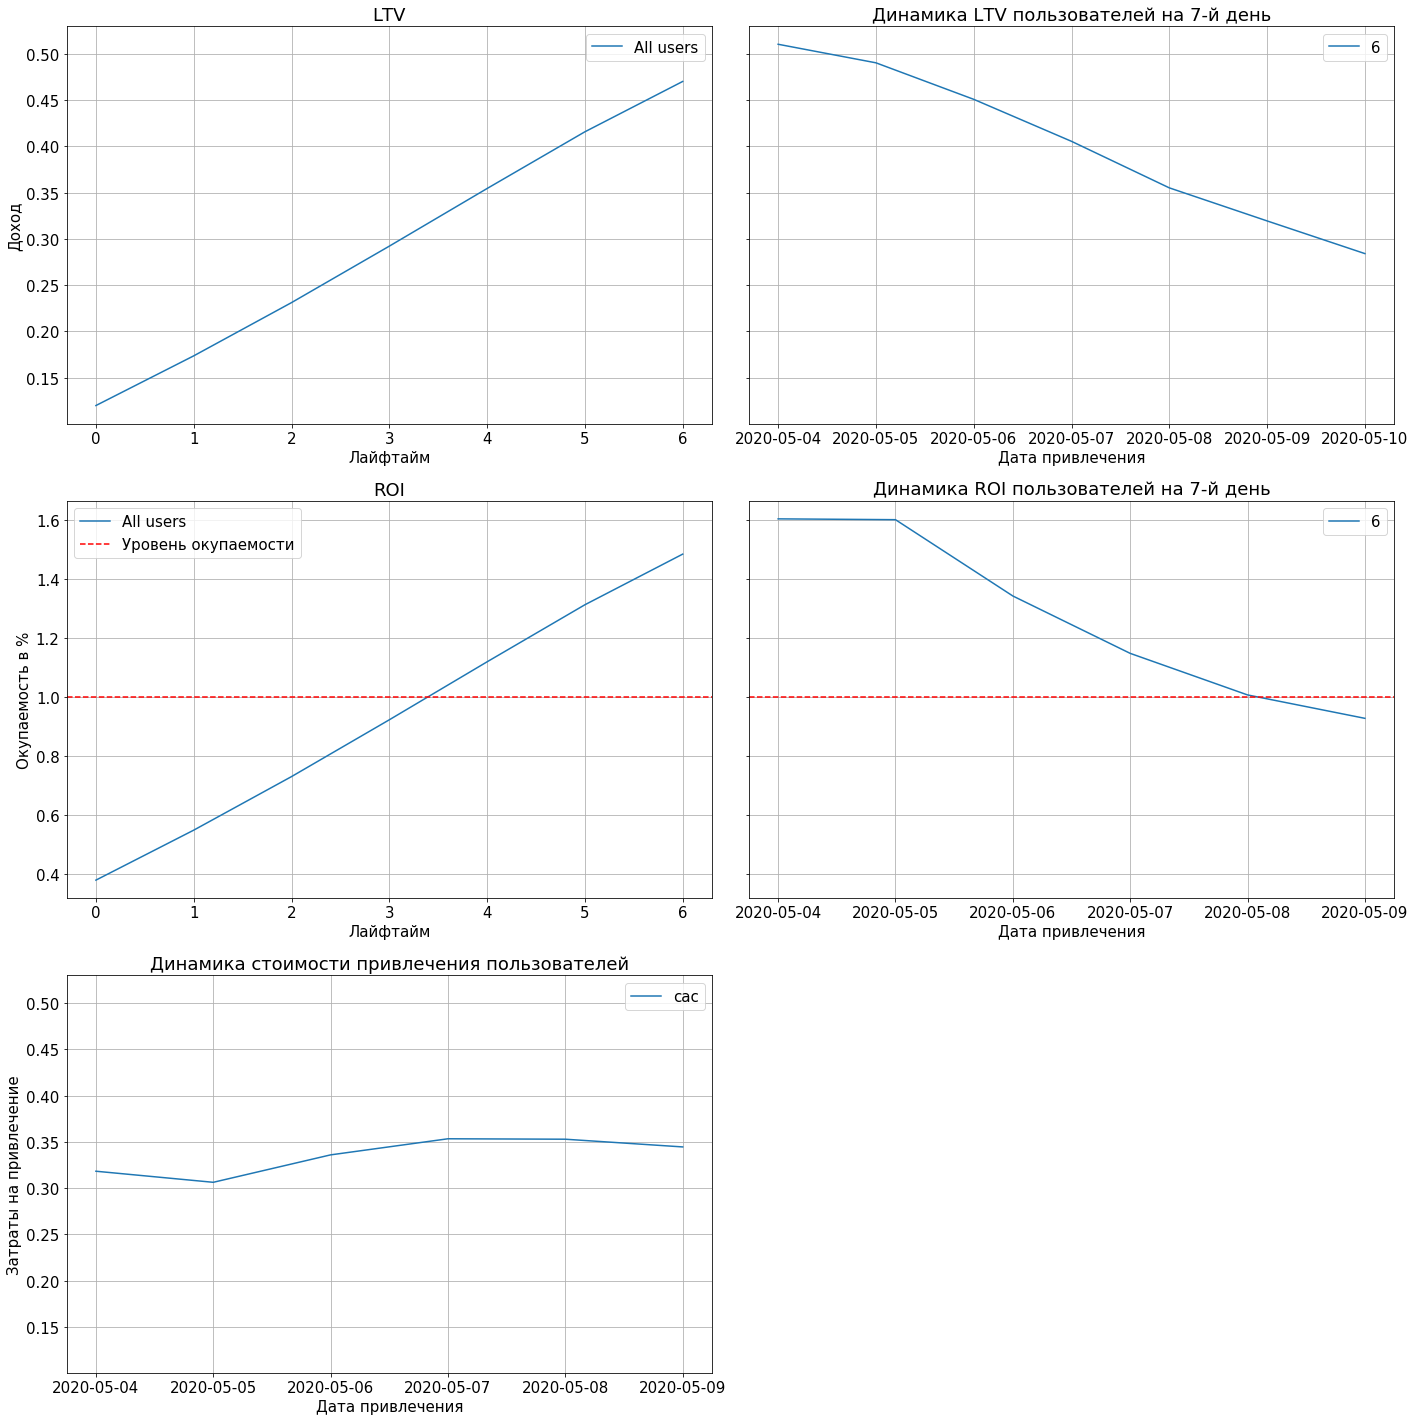

In [67]:
# построим графики, вызвав функцию plot_ltv_roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

##### Вывод:

* исходя из графикара спределения трат на рекламу во времени, видно, что реклама началась за день до того как пользователи начали пользоваться приложением.
* всех дороже обходится канал привлечения facebook_ads
* всех меньше уходит на рекламу в канале youtube_channel_reklama
* реклама показывалась в каналах с 3 до 9 мая включительно, затем прекратилась.
* распределение рекламных трат достаточно стабильно, только facebook_ads на третий день имел небольшие колебания.
* траты на привлечения окупаются очень хорошо ROI больше 140%
* траты на привлечение начали окупаться с четвертого дня.
* LTV в динамике падает, это говоит о том, что пользователи либо уходят, либо завершают первый уровень. Следовательно, показ рекламы не стоит сильно затягивать.
* первые 2 дня ROI стабилен.

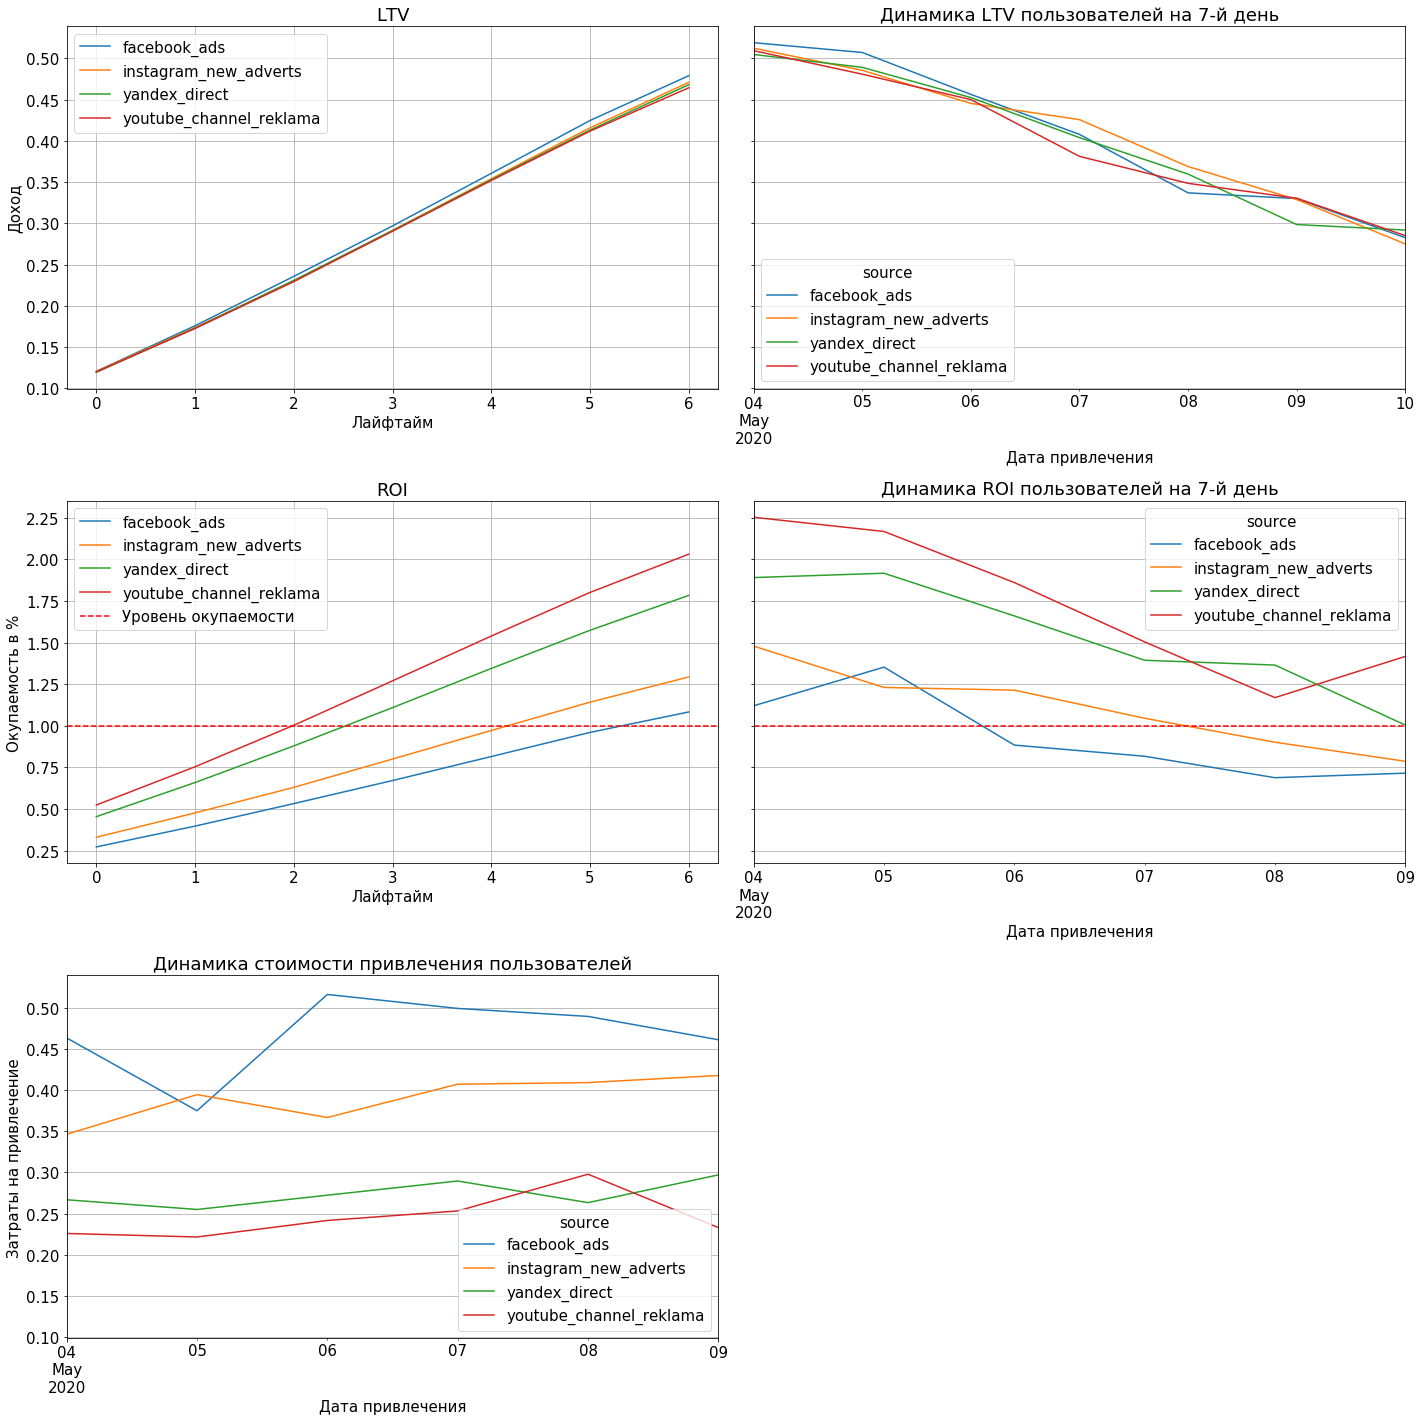

In [68]:
# посмотрим окупаемость с разбивкой по каналам

dimensions = ['source']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

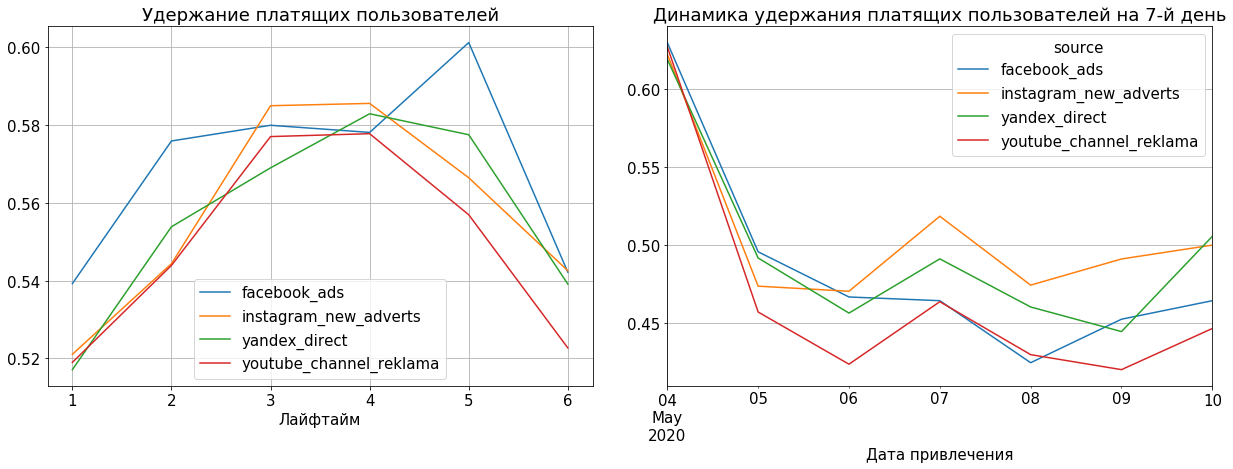

In [69]:
# Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, actions, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

##### Вывод:

* все 4 канала привлечения пользователей окупаются
* всех хуже окупается facebook_ads (на 6 день)
* всех лучше окупается youtube_channel_reklama (на 3 день)
* интересный момент на youtube траты на привлечения меньше, а окупаются такие пользователи всех лучше и наоборот на facebook_ads всех больше траты на привлечение и всех хуже он окупается.
* доход с просмотра рекламы у всех каналов уменьшается равномерно к 7 дню.
* facebook_ads перестает окупаться всех раньше, уже на 3 день
* yandex и youtube даже на седьмой день не уходят в минус
* динамика стоимости привлечения у всех каналов достаточно стабильна, кроме facebook_ads
* пока идет реклама видно по графику удержания, что идет рост удержания пользователей, с 4-5 дня начинает падать у всех.
* всех больше игроков в первый день, после запуска привлечения, а это значит именно в этот день мы можем больше всего получить доход с просмотра рекламы.

#### 2 вариант: показ рекламы со второй постройки

Смоделируем ситуацию, когда показ рекламы начнется с со второй постройки.


In [70]:
# сгрупируем по игрокам, выберем только событие building и найдем у каждого игрока время первого события
# так мы определим первую постройку
time_first_building = actions.query('event=="building"').groupby('user_id')['event_datetime'].first().reset_index()
time_first_building.head()

,user_id,event_datetime
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58


In [71]:
# выдели игроков из time_first_building
user_to_drop = time_first_building['user_id']

In [72]:
# выделим время первой постройки из time_first_building
time_to_drop = time_first_building['event_datetime']

In [73]:
# из таблице actions создадим row_to_drop в нее войдут только те игроки, которые есть в user_to_drop и в time_to_drop
row_to_drop = actions.query('user_id in @user_to_drop and event_datetime in @time_to_drop')

In [74]:
# создадим таблицу без первой постройки
# в начале соеденим таблицы actions и row_to_drop, а затем удалим дубли, тем самым удалим все первые постройки
without_first_building = pd.concat([actions, row_to_drop]).drop_duplicates(keep=False)
without_first_building.head(3)

,event_datetime,event,building_type,user_id,project_type,level_time,source,revenue,year,week,date
162,2020-05-04 00:30:27,building,assembly_shop,5118f7c5-0e54-4e46-afa6-1c7c8899a5ff,level_not_completed,10 days 00:22:01,yandex_direct,0.07,2020,19,2020-05-04
233,2020-05-04 00:46:04,building,assembly_shop,e97645cd-309f-42f9-8a2c-928540e76e63,level_not_completed,9 days 20:29:51,facebook_ads,0.07,2020,19,2020-05-04
296,2020-05-04 00:57:04,building,assembly_shop,92e9ba5d-c7d2-4297-979f-3c1065a13082,level_not_completed,NaT,instagram_new_adverts,0.07,2020,19,2020-05-04


Обновим таблицу revenue_ad с учетом, добавившихся нолей в столбце revenue

In [75]:
# получаем таблицу с user_id, event_datetime, revenue
revenue_ad = without_first_building[['user_id', 'event_datetime', 'revenue']]
# оставим в таблице только данные с показами реклам
revenue_ad = revenue_ad[revenue_ad['revenue'] > 0]
revenue_ad.head()

,user_id,event_datetime,revenue
162,5118f7c5-0e54-4e46-afa6-1c7c8899a5ff,2020-05-04 00:30:27,0.07
233,e97645cd-309f-42f9-8a2c-928540e76e63,2020-05-04 00:46:04,0.07
296,92e9ba5d-c7d2-4297-979f-3c1065a13082,2020-05-04 00:57:04,0.07
350,072c58ad-1501-434b-b38b-ce221cf4f12c,2020-05-04 01:05:31,0.07
388,1cc63c6c-54ac-4a36-b28d-1d012f32b127,2020-05-04 01:13:37,0.07


In [76]:
# Загрузим профили пользователей с учетом 2 варианта, для этого вызовем функцию get_profiles
profiles = get_profiles(actions, revenue_ad, ad_costs)
profiles.head()

,user_id,first_ts,source,day,month,payer,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,facebook_ads,2020-05-06,2020-05-01,True,0.515890
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,yandex_direct,2020-05-06,2020-05-01,True,0.272466
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,youtube_channel_reklama,2020-05-05,2020-05-01,True,0.221782
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,instagram_new_adverts,2020-05-05,2020-05-01,True,0.394436
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,facebook_ads,2020-05-05,2020-05-01,True,0.374907


Анализ общей окупаемости

In [77]:
# посчитаем LTV и ROI, вызвав функцию get_ltv
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days)

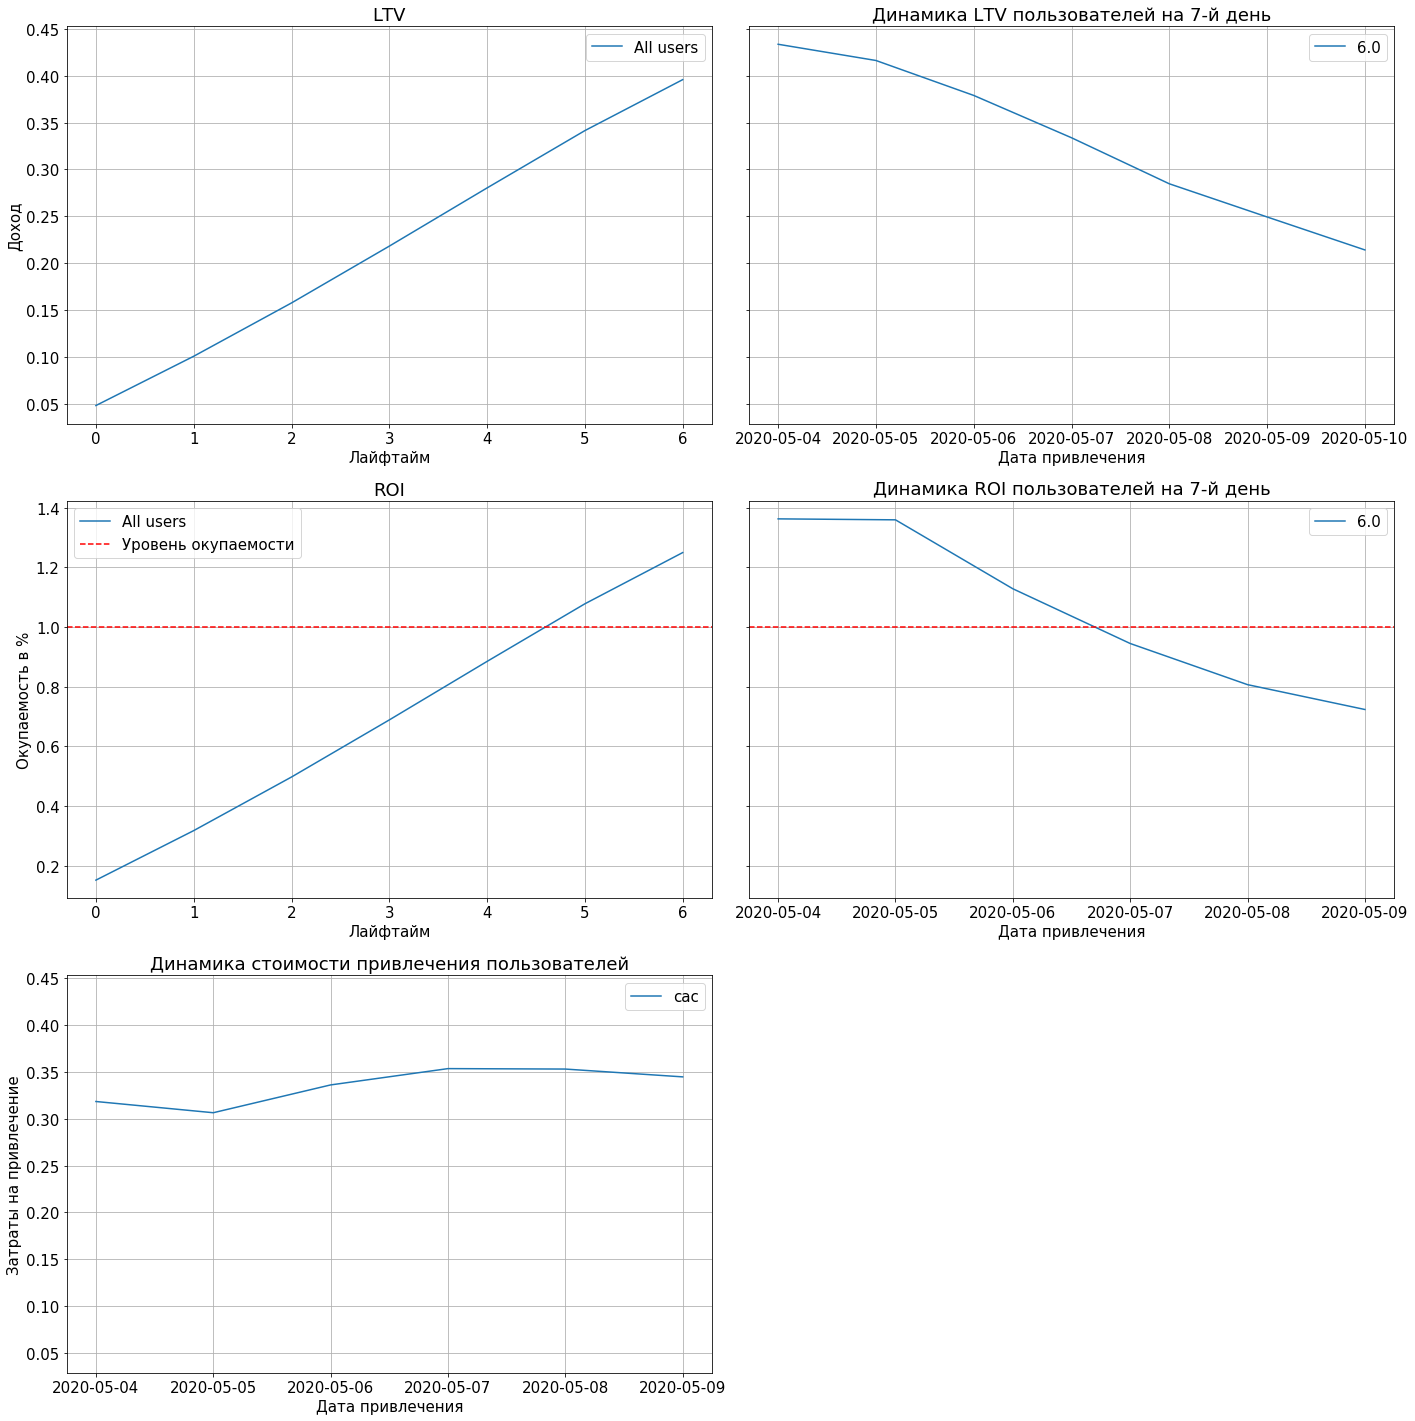

In [78]:
# построим графики, вызвав функцию plot_ltv_roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

##### Вывод: 

При втором варианте, когда реклама показывается со второй постройки, результаты дохода и окупаемости уступают первому варианту, но не критично:

* траты на привлечения окупаются хорошо ROI больше 120%
* траты на привлечение начали окупаться с пятого дня.
* LTV в динамике падает равномерно к 7 дню.
* первые 2 дня ROI так же стабилен как в 1 варианте.


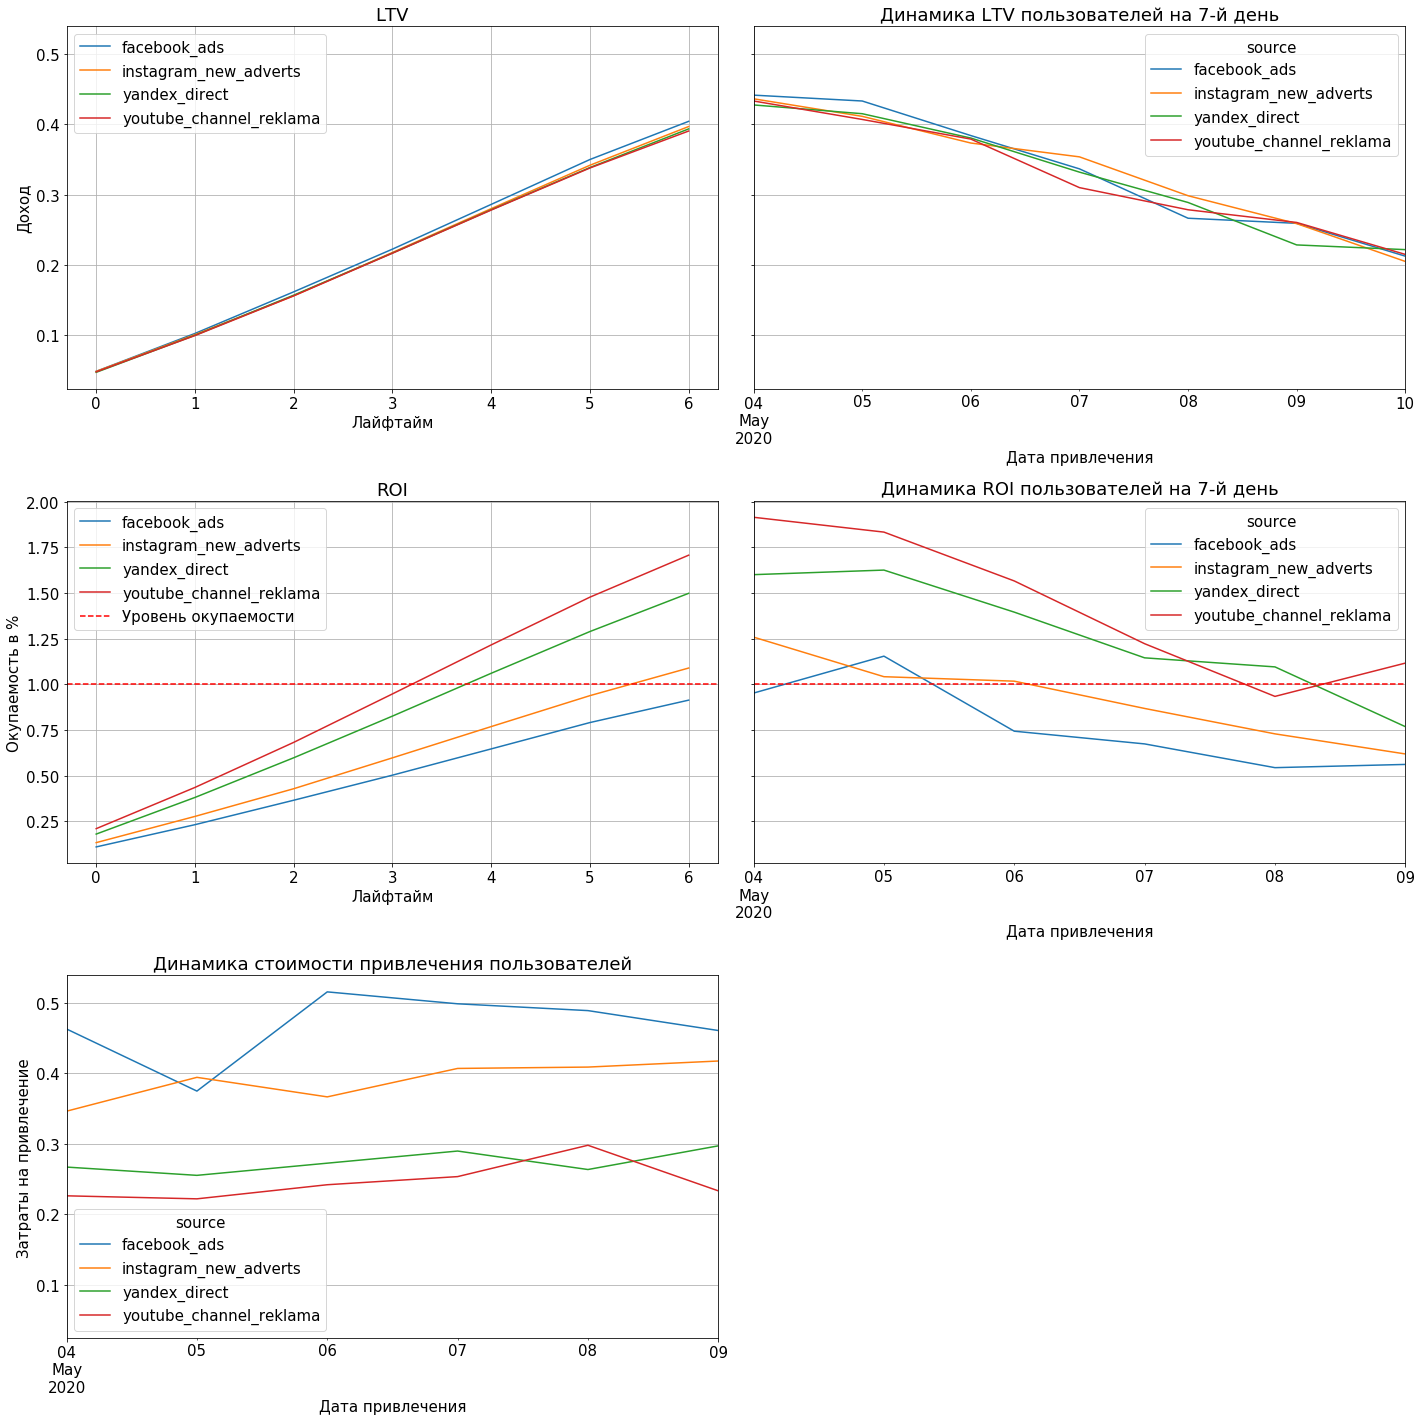

In [79]:
# посмотрим окупаемость с разбивкой по устройствам

dimensions = ['source']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

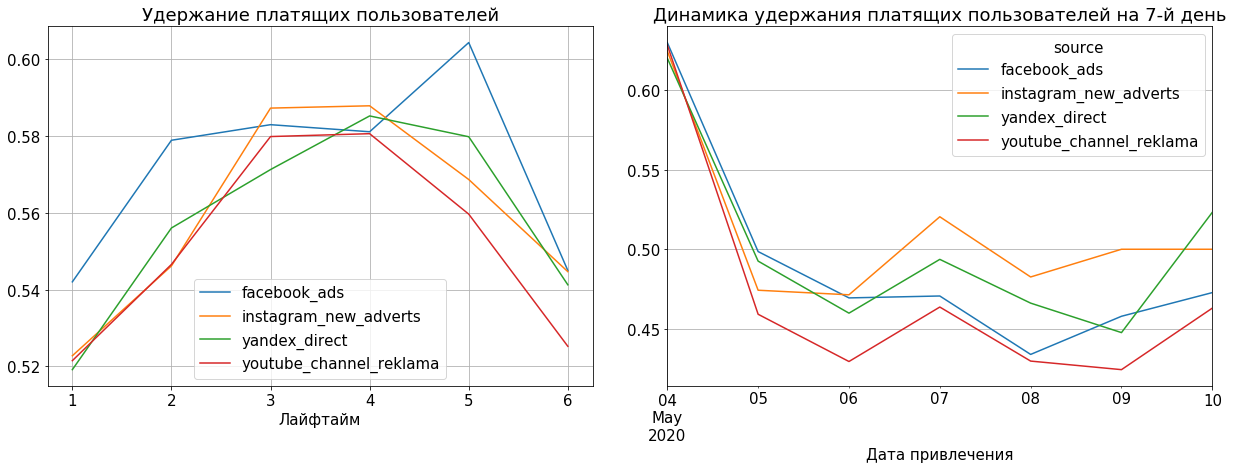

In [80]:
# Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, actions, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

##### Вывод:

* facebook_ads перестал окупаться.
* доход от просмотра рекламы у всех каналов так же падает к 7 дню равномерно.
* так же как и в 1 варианте, пока идет реклама видно по графику удержания, что идет рост пользователей, с 4-5 дня начинает падать у всех.


#### 3 вариант: показ рекламы с третий постройки

Смоделируем ситуацию, когда показ рекламы начинается с третьей постройки

Возьмем таблицу without_first_building (без первой постройки) и к ней применим все теже действия, что во 2 варианте и удалим уже из нее первую постройку, на самом деле она уже будет являться второй, так мы начнем показ рекламы как будто с третьей постройки.

In [81]:
# сгрупируем по игрокам, выберем только событие building и найдем у каждого игрока время первого события
# так мы определим первую постройку
time_first_building_1 = without_first_building.query('event=="building"').groupby('user_id')['event_datetime'].first().reset_index()
time_first_building_1.head()

,user_id,event_datetime
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 11:31:56
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 11:00:18
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 20:34:38
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-06 10:52:38
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-09 05:33:26


In [82]:
# выдели игроков из time_first_building
user_to_drop_1 = time_first_building_1['user_id']

In [83]:
# выделим время первой постройки из time_first_building
time_to_drop_1 = time_first_building_1['event_datetime']

In [84]:
# из таблице actions создадим row_to_drop в нее войдут только те игроки, которые есть в user_to_drop и в time_to_drop
row_to_drop_1 = without_first_building.query('user_id in @user_to_drop_1 and event_datetime in @time_to_drop_1')

In [85]:
# создадим таблицу без первой постройки
# в начале соеденим таблицы actions и row_to_drop, а затем удалим дубли, тем самым удалим все первые постройки
without_second_building = pd.concat([without_first_building, row_to_drop_1]).drop_duplicates(keep=False)
without_second_building.head(3)

,event_datetime,event,building_type,user_id,project_type,level_time,source,revenue,year,week,date
1248,2020-05-04 03:52:52,building,spaceport,0d78d170-f849-4599-b6af-0c7135a0678a,level_not_completed,13 days 21:51:41,yandex_direct,0.07,2020,19,2020-05-04
1253,2020-05-04 03:54:16,building,spaceport,a430098a-fb28-4dc2-86dd-fb06b3a103f8,level_not_completed,12 days 01:46:56,youtube_channel_reklama,0.07,2020,19,2020-05-04
1506,2020-05-04 04:43:32,building,assembly_shop,25b42909-acbc-4402-8c2b-41447bb39cc3,level_not_completed,NaT,yandex_direct,0.07,2020,19,2020-05-04


Обновим таблицу revenue_ad с учетом, удаления всех первых построек

In [86]:
# получаем таблицу с user_id, event_datetime, revenue
revenue_ad = without_second_building[['user_id', 'event_datetime', 'revenue']]
# оставим в таблице только данные с показами реклам
revenue_ad = revenue_ad[revenue_ad['revenue'] > 0]
revenue_ad.head()

,user_id,event_datetime,revenue
1248,0d78d170-f849-4599-b6af-0c7135a0678a,2020-05-04 03:52:52,0.07
1253,a430098a-fb28-4dc2-86dd-fb06b3a103f8,2020-05-04 03:54:16,0.07
1506,25b42909-acbc-4402-8c2b-41447bb39cc3,2020-05-04 04:43:32,0.07
1843,dd1477eb-9d20-400b-8718-ce7272e47d36,2020-05-04 05:49:16,0.07
1970,d0d80f1e-592c-4f2f-ab4e-8fec6a0221ab,2020-05-04 06:10:36,0.07


In [87]:
# Загрузим профили пользователей с учетом 2 варианта, для этого вызовем функцию get_profiles
profiles = get_profiles(actions, revenue_ad, ad_costs)
profiles.head()

,user_id,first_ts,source,day,month,payer,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,facebook_ads,2020-05-06,2020-05-01,True,0.515890
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,yandex_direct,2020-05-06,2020-05-01,True,0.272466
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,youtube_channel_reklama,2020-05-05,2020-05-01,True,0.221782
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,instagram_new_adverts,2020-05-05,2020-05-01,True,0.394436
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,facebook_ads,2020-05-05,2020-05-01,True,0.374907


Анализ общей окупаемости

In [88]:
# посчитаем LTV и ROI, вызвав функцию get_ltv
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days)

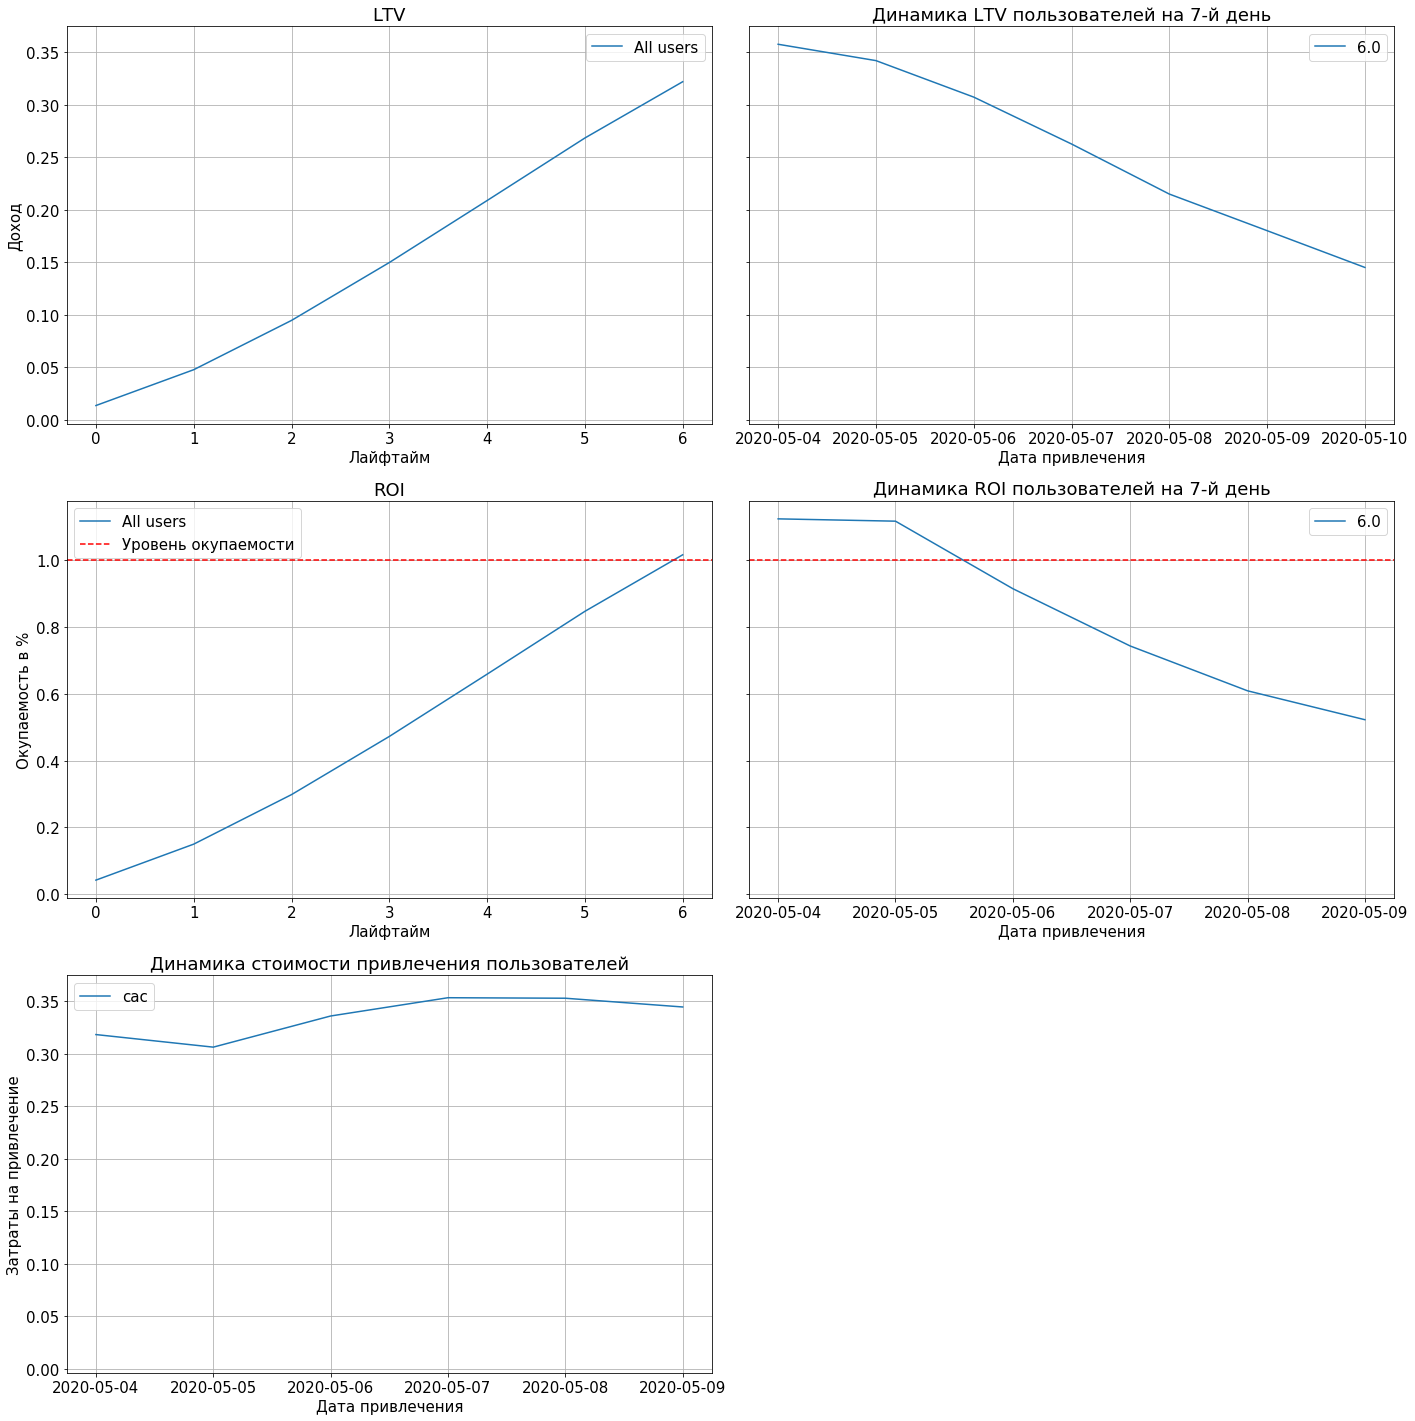

In [89]:
# построим графики, вызвав функцию plot_ltv_roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

##### Вывод:

При третьем варианте, когда реклама показывается с третьей постройки, результаты дохода и окупаемости становятся хуже по сравнению 1 и 2 вариантом.

* траты на привлечения окупаются на 7 день, выходят в 0, без дохода.
* LTV в динамике падает равномерно к 7 дню.


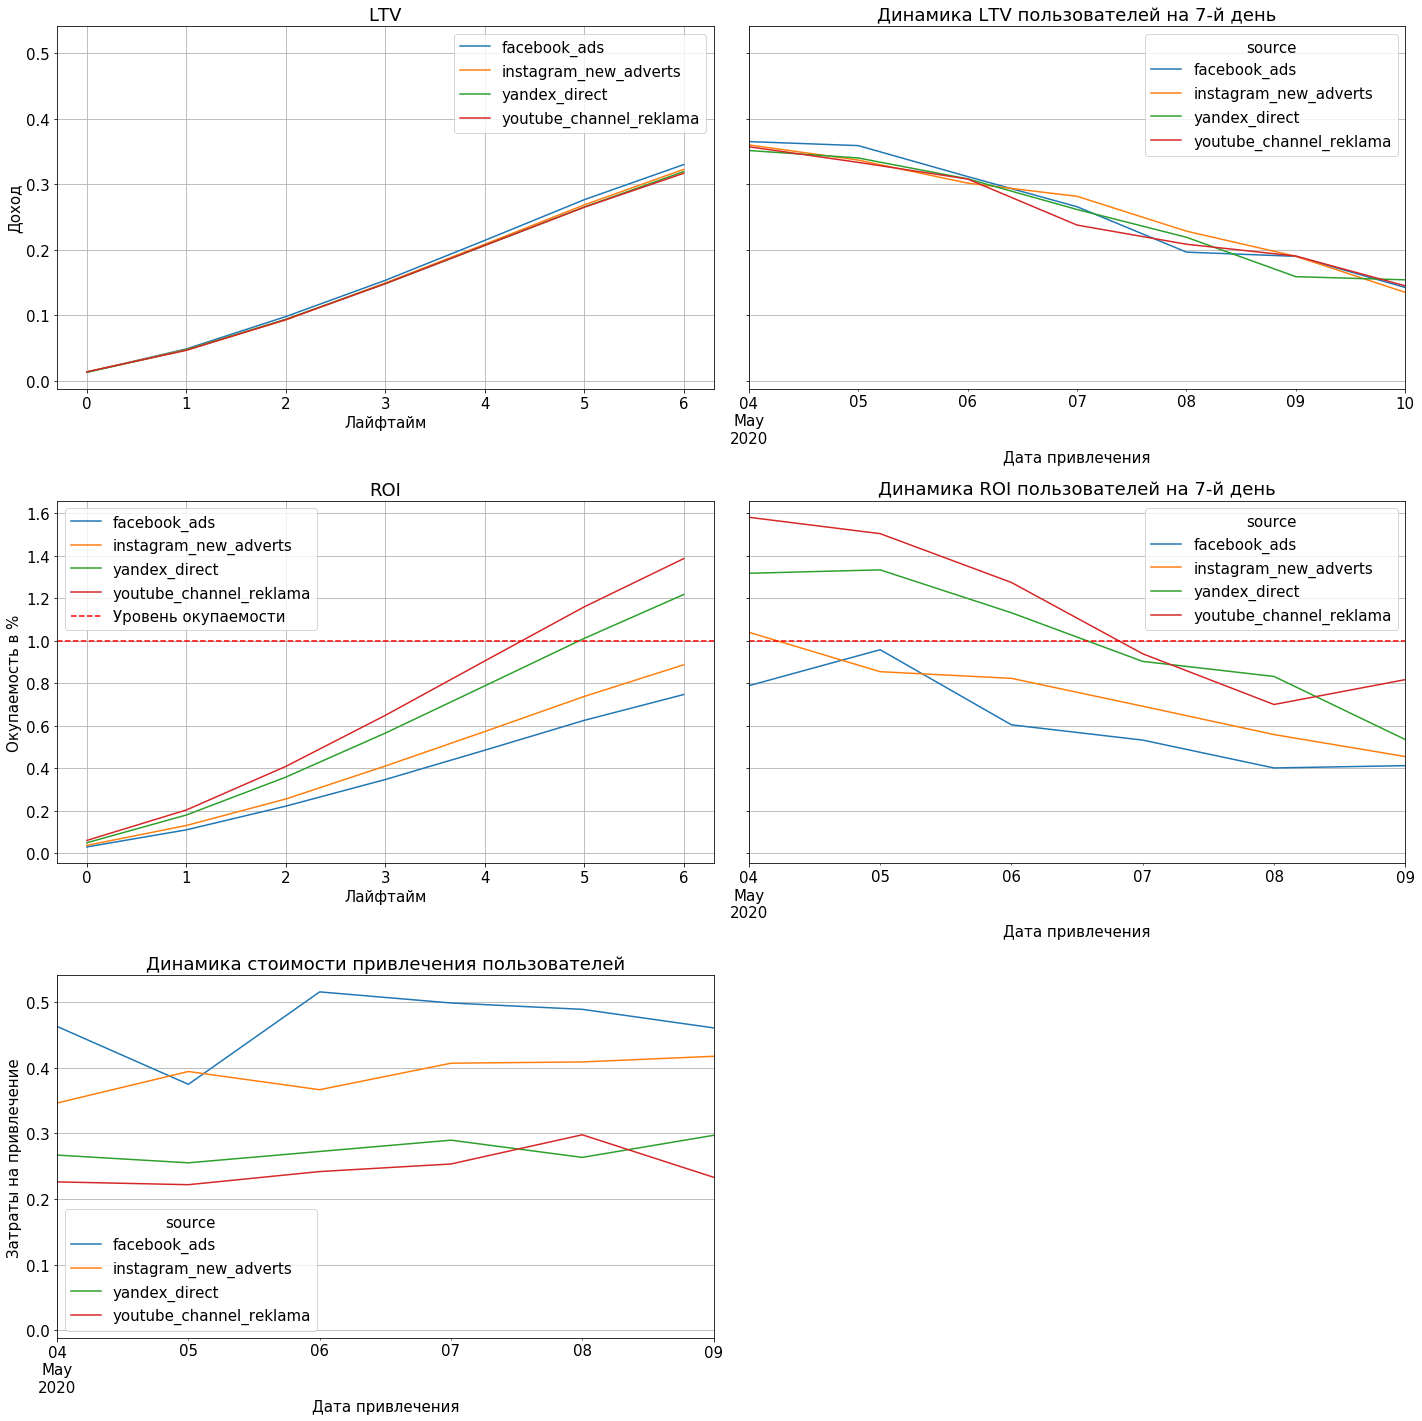

In [90]:
# посмотрим окупаемость с разбивкой по устройствам

dimensions = ['source']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, revenue_ad, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=1) 

##### Вывод:

* уже два канала перестают окупаться, к facebook_ads прибавился instagram.
* окупаемость падает быстрее, уже с 4 дня перестают окупаться те каналы, у которых хорошие показатели это youtube и yandex

## Проверка гипотез

**Гипотеза №1: Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком разное.**

**Нулевая гипотеза:** время прохождения уровня у пользователей, которые заканчивают уровень через реализацию проекта и пользователями, которые заканчивают уровень победой над противником равно.

**Альтернативная гипотеза:** время прохождения уровня у пользователей, которые заканчивают уровень через реализацию проекта и пользователями, которые заканчивают уровень победой над противником не равно.

In [91]:
# переведем столбец level_time в часы
actions['level_time_h'] = actions['level_time'] / np.timedelta64(1, 'h')

In [92]:
# в столбце level_time_h заполняем пропуски не завершивших уровень пользователей нолями
actions.loc[actions['level_time_h'].isna(), 'level_time_h'] = 0

In [93]:
('Среднее время прохождения 1 уровня пользователей через реализацию проекта',
 round(actions.query('project_type=="satellite_orbital_assembly"')['level_time_h'].mean(),2))

('Среднее время прохождения 1 уровня пользователей через реализацию проекта',
 323.01)

In [94]:
('Среднее время прохождения 1 уровня пользователей через победу над врагом',
 round(actions.query('project_type=="victory_over_enemy"')['level_time_h'].mean(),2))

('Среднее время прохождения 1 уровня пользователей через победу над врагом',
 284.63)

In [95]:
# выборка времени прохождения уровня у пользователей, которые заканчивают уровень через реализацию проекта
satellite_orbital_assembly = actions.query('project_type=="satellite_orbital_assembly"')['level_time_h']

In [96]:
# выборка времени прохождения уровня у пользователей, которые заканчивают уровень победой над противником
victory_over_enemy = actions.query('project_type=="victory_over_enemy"')['level_time_h']

In [97]:
alpha = 0.05 

results = st.ttest_ind(satellite_orbital_assembly, victory_over_enemy)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.133459164109125e-52
Отвергаем нулевую гипотезу


**Гипотеза №2: Средние затраты на привлечения игроков отличаются между пользователями, которые прошли первый уровень и тех, кто его не прошел.**

**Нулевая гипотеза:** средние затраты на привлечения игроков у пользователей, которые прошли первый уровень и пользователей, которые не прошли равны.

**Альтернативная гипотеза:** средние затраты на привлечения игроков у пользователей, которые прошли первый уровень и пользователей, которые не прошли не равны.

In [98]:
# создадим таблицу где будет user_id, project_type и acquisition_cost (средние затраты на привлечения)
df = actions[['user_id', 'project_type']].merge(profiles[['user_id', 'acquisition_cost']], on= 'user_id', how='left')
df.head()

,user_id,project_type,acquisition_cost
0,55e92310-cb8e-4754-b622-597e124b03de,level_not_completed,0.226067
1,c07b1c10-f477-44dc-81dc-ec82254b1347,level_not_completed,0.463137
2,6edd42cc-e753-4ff6-a947-2107cd560710,level_not_completed,0.346367
3,92c69003-d60a-444a-827f-8cc51bf6bf4c,level_not_completed,0.463137
4,cdc6bb92-0ccb-4490-9866-ef142f09139d,level_not_completed,0.266916


In [99]:
('Средние затраты игроков кто прошел 1 уровень',
 round(df.query('project_type!="level_not_completed"')['acquisition_cost'].mean(),2))

('Средние затраты игроков кто прошел 1 уровень', 0.32)

In [100]:
('Средние затраты игроков кто не прошел 1 уровень',
 round(df.query('project_type=="level_not_completed"')['acquisition_cost'].mean(),2))

('Средние затраты игроков кто не прошел 1 уровень', 0.32)

In [101]:
# выборка средних затрат на привлечение у пользователей, которые прошли первый уровень
level_completed = df.query('project_type!="level_not_completed"')['acquisition_cost']

In [102]:
# выборка средних затрат на привлечение у пользователей, которые не прошли первый уровень
level_not_completed = df.query('project_type=="level_not_completed"')['acquisition_cost']

In [103]:
alpha = 0.05 

results = st.ttest_ind(level_completed, level_not_completed)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5460375192160081
Не получилось отвергнуть нулевую гипотезу


### Вывод:

* По первой гепотезе, P-значение достаточно мало, что даёт основание отвергнуть предположение о равенстве между временем прохождения уровня у пользователей, которые закончили уровень через реализацию проекта и пользователей, закончивших победой над врагом.
* По второй гепотезе, P-значение составляет 54.6%, это слишком высокая вероятность для того, чтобы делать выводы о значимом различии между между средними затратами на привлечения у пользователей прошедших 1 уровень и не прошедших.

## Общие выводы и рекомендации

**I. Перед анализом, мы подготовили данные, а именно:**


В таблице actions:
   
* Заменили пропуски исходя из произошедших событий в event в столбцах:
     * project_type:
          * на satellite_orbital_assembly, если в event стоит project,
          * на victory_over_enemy, если в event стоит finished_stage_1,
          * на level_not_completed, если в event стоит building.
     * building_type:
          * на project_is_built, если в event стоит finished_stage_1, либо project.
* Заменили тип данных в столбце event_datetime на datetime.
* Добавили новые столбцы в таблицу actions: level_time, source, revenue.
* Удалили один явный дубликат.
      

**II. Исследовательский анализ данных:**

* Доля игроков, которые завершили 1 уровень от общего числа игроков - 56,59%
* Всех больше игроков приходит с канала - "yandex_direct" 35,48%, всех меньше с канала youtube_channel_reklama 19,78%
* Затраты на маркетинг от общего бюджета:
   * yandex_direct - 29.37%
   * instagram_new_adverts - 28.43%
   * facebook_ads - 28.16%
   * youtube_channel_reklama - 14.05%
* 93.10% - игроков на стадии постройки зданий, 5.23% - завершили уровень победой над врагом, 1.68% - реализовали проект
* самая популярная постройка spaceport (47,72% доля от всех построек)
* Максимальное количество построек на игрока - 20
* Минимальное количество построек на игрока  - 1 
* Среднее количество построек на игрока - 9,43
* Больше всего строят всего 1 постройку (около 8000 игроков)

**III. Расчет бизнес-показателей:**

1.  Пользовательская активность:
   * Количество уникальных пользователей в день ~ 2885
   * Количество уникальных пользователей в неделю - 6120
   * Регулярно возвращаются в игру - 47,14% 


2. Было рассмотрено 3 варианта показа рекламы:
   * 1 вариант - рекламу начинаем показывать с первой постройки,
   * 2 вариант - рекламу начинаем показывать со второй постройки.
   * 3 вариант - рекламу начинаем показывать с третьей постройки.
   
   Для анализа было выбраны:
   * Момент анализа - 05.06.2020
   * Горизонт анализа - 7 дней
   
   
По 1 варианту, можно сказать:

* исходя из графика распределения трат на рекламу во времени, видно, что реклама началась за день до того как пользователи начали пользоваться приложением.
* всех дороже обходится канал привлечения facebook_ads
* всех меньше уходит на рекламу в канале youtube_channel_reklama
* реклама показывалась в каналах с 3 до 9 мая включительно, затем прекратилась.
* распределение рекламных трат достаточно стабильно, только facebook_ads на третий день имел небольшие колебания.
* траты на привлечения окупаются очень хорошо ROI больше 140%
* LTV в динамике падает, это говоит о том, что пользователи либо уходят, либо завершают первый уровень. Следовательно, показ рекламы не стоит сильно затягивать.
* траты на привлечение начали окупаться с четвертого дня.
* первые 2 дня ROI стабилен.

С разбивкой по каналам:
* все 4 канала привлечения пользователей окупаются
* всех хуже окупается facebook_ads (на 6 день)
* всех лучше окупается youtube_channel_reklama (на 3 день)
* интересный момент на youtube траты на привлечения меньше, а окупаются такие пользователи всех лучше и наоборот на facebook_ads всех больше траты на привлечение и всех хуже он окупается.
* доход с просмотра рекламы у всех каналов уменьшается равномерно к 7 дню.
* facebook_ads перестает окупаться всех раньше, уже на 3 день
* yandex и youtube даже на седьмой день не уходят в минус
* динамика стоимости привлечения у всех каналов достаточно стабильна, кроме facebook_ads
* пока идет реклама видно по графику удержания, что идет рост удержания пользователей, с 4-5 дня начинает падать у всех.
* всех больше игроков в первый день, после запуска рекламы, а это значит именно в этот день мы можем больше всего получить доход с просмотра рекламы.


По 2 варианту можно сказать:

Когда реклама показывается со второй постройки, результаты дохода и окупаемости уступают первому варианту, но не критично:

* траты на привлечения окупаются хорошо ROI больше 120%
* траты на привлечение начали окупаться с пятого дня.
* LTV в динамике падает равномерно к 7 дню.
* первые 2 дня ROI так же стабилен как в 1 варианте.


С разбивкой по каналам:

* facebook_ads перестал окупаться.
* доход от просмотра рекламы у всех каналов так же падает к 7 дню равномерно.
* так же как и в 1 варианте, пока идет реклама видно по графику удержания, что идет рост пользователей, с 4-5 дня начинает падать у всех.


По 3 варианту можно сказать:

Когда реклама показывается с третьей постройки, результаты дохода и окупаемости становятся хуже по сравнению 1 и 2 вариантом.

* траты на привлечения окупаются на 7 день, выходят в 0, без дохода.
* LTV в динамике падает равномерно к 7 дню.


С разбивкой по каналам:

* уже два канала перестают окупаться, к facebook_ads прибавился instagram.
* окупаемость падает быстрее, уже с 4 дня перестают окупаться те каналы, у которых хорошие показатели это youtube и yandex

**IV. Проверка гипотез:**

Мы проверили две гипотезы при помощи ttest.

**Гипотеза №1:** Время прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком разное. - получив P-значение очень маленькое мы отвергли нулевую гипотезу о равенстве времени прохождения уровня между игроками, закончившими уровень реализацией проекта и победой над игроком.

**Гипотеза №2:** Средние затраты на привлечения игроков отличаются между пользователями, которые прошли первый уровень и тех, кто его не прошел - получив P-значение 54,6% мы не отвергли нулевую гипотезу, и предположили, что различия между средними тратами на привлечение не велико между пользователями которые прошли уровень и теми кто его не прошел.

**V. Рекомендации:**

* Оптимальное время для запуска рекламы - показывать ее со второй постройки, так игроки меньше будут злиться на рекламу и в тоже время показатели окупаемости хорошие и доход создателям игры должен быть хороший.
* К тому же, если рассмотреть вариант, не покупать рекламу для привлечения пользователей у канала facebook_ads, затраты на нее всех выше, а окупаемость при втором варианте и вообще не достигается, это может привести к улутшению всех метрик и тем самым создали при 2 варианте показа рекламы начнут зарабатывать еще больше.
* А вот пользователи, пришедшие с канала youtube_channel_reklama, приносят всех больше прибыли и на них всех меньше затрат на привлечение и это с учетом что из этого канала приходят всего лишь 19.78% от всех зарегистрированных, стоит рассмотреть вариант увеличить затраты на рекламу в данном канале, это может превести к еще большему улучшению всех показателей.